# Pylops - Least squares migration (distributed)

### Author: M.Ravasi

In this notebook we will extend the Least squares Migration example to work with distributed operators.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import skfmm
import dask.array as da
import pylops
import pylops_distributed

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.signal import convolve, filtfilt

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import Spread
from pylops.signalprocessing           import *

from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

from pylops_distributed.basicoperators import Spread as Spread_distr
from pylops_distributed.waveeqprocessing.lsm import _traveltime_table, Demigration, LSM

In [2]:
client = pylops_distributed.utils.backend.dask()
client

Client Scheduler: tcp://127.0.0.1:60244 Dashboard: http://127.0.0.1:60245/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


## 2D layered in homogenous velocity

Lets' create a model and geometry

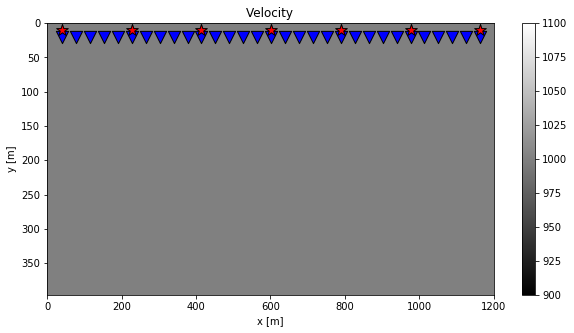

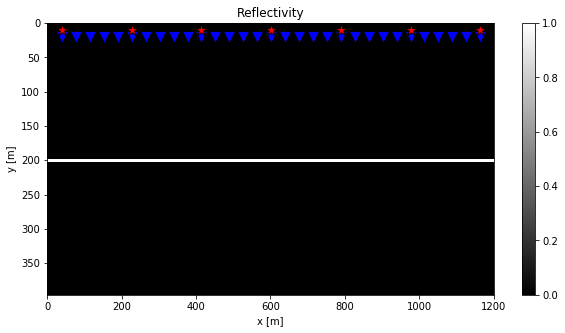

In [3]:
# Velocity Model
nx, nz = 301, 100
dx, dz = 4, 4
x, z = np.arange(nx)*dx, np.arange(nz)*dz
v0 = 1000 # initial velocity
kv = 0. # gradient
vel = np.outer(np.ones(nx), v0 +kv*z) 

# Reflectivity Model
refl = np.zeros((nx, nz))
refl[:, nz//2] = 1

# Receivers
nr = 31
rx = np.linspace(10*dx, (nx-10)*dx, nr)
rz = 20*np.ones(nr)
recs = np.vstack((rx, rz))
dr = recs[0,1]-recs[0,0]

# Sources
ns = 7
sx = np.linspace(dx*10, (nx-10)*dx, ns)
sz = 10*np.ones(ns)
sources = np.vstack((sx, sz))
ds = sources[0,1]-sources[0,0]

plt.figure(figsize=(10,5))
im = plt.imshow(vel.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Velocity')
plt.xlim(x[0], x[-1])

plt.figure(figsize=(10,5))
im = plt.imshow(refl.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Reflectivity')
plt.xlim(x[0], x[-1]);

We can create now the LSM object

In [5]:
nt = 651
dt = 0.004
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=20)

lsm = LSM(z, x, t, sources, recs, vel, wav, wavc,
          mode='eikonal', nprocesses=len(client.ncores()))

We model the data and compute the adjoint model (=image)

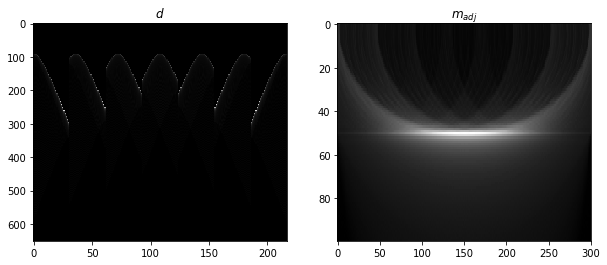

In [7]:
d = lsm.Demop.matvec(refl.flatten())
dcomp = d.compute()

madj = lsm.Demop.rmatvec(d.flatten())
madjcomp = madj.compute()

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(dcomp.reshape(ns*nr, nt).T, cmap='gray')
axs[0].set_title(r'$d$')
axs[0].axis('tight');
axs[1].imshow(madjcomp.reshape(nx, nz).T, cmap='gray')
axs[1].set_title(r'$m_{adj}$')
axs[1].axis('tight');

Finally we invert the model

In [ ]:
minv = lsm.solve(d, solver=lsqr, **dict(iter_lim=20, show=True))
minv = minv.compute()

 
LSQR            Least-squares solution of  Ax = b
The matrix A has   141267 rows  and    30100 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       20
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   5.477e+02  5.477e+02    1.0e+00  1.4e-01
     1  1.15785e-02   4.740e+02  4.740e+02    8.7e-01  4.8e-01   1.5e+02  1.0e+00
     2  1.46025e-02   4.578e+02  4.578e+02    8.4e-01  1.0e-01   3.5e+02  2.7e+00
     3  1.55474e-02   4.556e+02  4.556e+02    8.3e-01  6.6e-02   5.2e+02  4.5e+00
     4  1.75606e-02   4.522e+02  4.522e+02    8.3e-01  5.2e-02   6.9e+02  8.0e+00
     5  1.83557e-02   4.512e+02  4.512e+02    8.2e-01  3.0e-02   9.2e+02  1.2e+01
     6  1.93655e-02   4.502e+02  4.502e+02    8.2e-01  3.1e-02   1.1e+03  1.6e+01
     7  2.03276e-02   4.493e+02  4.493e+02    8.2e-01  1.9e-02   1.3e+03  2.3e+01
     8  2.08421e-02   4.489e

In [ ]:
minv = minv.compute()
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(refl.T, cmap='gray')
axs[0].set_title(r'$m$')
axs[0].axis('tight')
axs[1].imshow(minv.T, cmap='gray')
axs[1].set_title(r'$m_{inv}$')
axs[1].axis('tight');